In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
data_path = 'data/2017-20211231_15min.csv'

data = pd.read_csv(data_path)
data = data[(data['timestamp'] >= '2017-11-09') & (data['timestamp'] <= '2021-12-31')]
data = data.drop(['timestamp'], axis=1)

data.head()

,price_open,price_high,price_low,price_close,volume_traded,MACD,SMA,OBV,RSI,MFI,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count
6624,7465.06,7466.57,7358.24,7388.03,231.027218,212.126533,7428.970,17223.07556,49.326753,89.285741,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6625,7388.67,7438.40,7388.67,7437.69,95.469208,216.088015,7442.108,17318.54477,49.371641,89.838060,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6626,7438.41,7440.40,7321.01,7355.56,461.798282,209.536334,7420.154,16856.74649,48.237061,79.862237,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6627,7355.26,7360.00,7295.43,7360.00,145.786407,209.890522,7398.320,17002.53289,46.564386,92.908600,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6628,7360.00,7392.66,7335.61,7368.41,102.199117,210.561405,7381.938,17104.73201,45.076158,96.591717,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator in 30 MIN data:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count', 'pos_keywords_occur', 'neg_keywords_occur'], axis=1)

'''Price Data + Selected Features'''
data_features = data.drop(['price_close', 'MFI', 'vader_compound',	'pos_count', 'neg_count', 'neu_count'], axis=1)

data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))


train_size1 = int(0.8 * len(label))
train_size2 = int(0.9 * len(label))

In [4]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

window_size = 5

X_train, y_train = split_data(feature[:train_size1], label[:train_size1], window_size)
X_train2, y_train2 = split_data(feature[train_size1:train_size2], label[train_size1:train_size2], window_size)
X_test, y_test = split_data(feature[train_size2:], label[train_size2:], window_size)

# Define Base Models

In [5]:
nGRU = 7
nLSTM = 3

In [6]:
GRUs = [
    keras.Sequential([
        layers.GRU(512),
        layers.Dense(512),
        layers.Dense(1)
    ]) for i in range(nGRU)
]

LSTMs = [
    keras.Sequential([
        layers.LSTM(512),
        layers.Dropout(0.2),
        layers.Dense(1)
    ]) for i in range(nLSTM)
]

2022-11-08 14:56:29.489544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 14:56:29.497597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 14:56:29.497852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 14:56:29.498617: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Train Models

In [7]:
for i, model in enumerate(GRUs):
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                  metrics=[keras.metrics.RootMeanSquaredError()]
                  )
    history = model.fit(X_train, y_train,
                        epochs=70,
                        batch_size=64,
                        validation_data=(X_train2, y_train2),
                        callbacks=[keras.callbacks.ModelCheckpoint('gru-15min-'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
                        shuffle=True
                        )

/home/charles/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-11-08 14:56:30.132988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-11-08 14:56:31.807385: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400


1816/1816 [==============================] - 9s 4ms/step - loss: 6.4928e-04 - root_mean_squared_error: 0.0255 - val_loss: 1.0330e-05 - val_root_mean_squared_error: 0.0032

Epoch 00001: val_root_mean_squared_error improved from inf to 0.00321, saving model to gru-15min-0.h5
Epoch 2/70
1816/1816 [==============================] - 6s 3ms/step - loss: 3.6035e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.6631e-04 - val_root_mean_squared_error: 0.0129

Epoch 00002: val_root_mean_squared_error did not improve from 0.00321
Epoch 3/70
1816/1816 [==============================] - 7s 4ms/step - loss: 9.1134e-06 - root_mean_squared_error: 0.0030 - val_loss: 2.4983e-04 - val_root_mean_squared_error: 0.0158

Epoch 00003: val_root_mean_squared_error did not improve from 0.00321
Epoch 4/70
1816/1816 [==============================] - 6s 3ms/step - loss: 8.6937e-06 - root_mean_squared_error: 0.0029 - val_loss: 1.6111e-04 - val_root_mean_squared_error: 0.0127

Epoch 00004: val_root_mean_squared_er

In [8]:
for i, model in enumerate(LSTMs):
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                  metrics=[keras.metrics.RootMeanSquaredError()]
                  )
    history = model.fit(X_train, y_train,
                        epochs=70,
                        batch_size=64,
                        validation_data=(X_train2, y_train2),
                        callbacks=[keras.callbacks.ModelCheckpoint('lstm-15min-'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
                        shuffle=True
                        )

Epoch 1/70
1816/1816 [==============================] - 6s 3ms/step - loss: 1.3933e-04 - root_mean_squared_error: 0.0118 - val_loss: 8.4585e-05 - val_root_mean_squared_error: 0.0092

Epoch 00001: val_root_mean_squared_error improved from inf to 0.00920, saving model to lstm-15min-0.h5
Epoch 2/70
1816/1816 [==============================] - 5s 3ms/step - loss: 3.4585e-05 - root_mean_squared_error: 0.0059 - val_loss: 1.2179e-05 - val_root_mean_squared_error: 0.0035

Epoch 00002: val_root_mean_squared_error improved from 0.00920 to 0.00349, saving model to lstm-15min-0.h5
Epoch 3/70
1816/1816 [==============================] - 5s 3ms/step - loss: 2.9354e-05 - root_mean_squared_error: 0.0054 - val_loss: 7.9809e-05 - val_root_mean_squared_error: 0.0089

Epoch 00003: val_root_mean_squared_error did not improve from 0.00349
Epoch 4/70
1816/1816 [==============================] - 5s 3ms/step - loss: 2.6537e-05 - root_mean_squared_error: 0.0052 - val_loss: 3.8435e-04 - val_root_mean_squared_err

# Predict Results for Base Models

In [9]:
GRU = [tf.keras.models.load_model('gru-15min-'+str(i)+'.h5') for i in range(nGRU)]
LSTM = [tf.keras.models.load_model('lstm-15min-'+str(i)+'.h5') for i in range(nLSTM)]

In [10]:
pred_GRU = [model.predict(X_test) for model in GRU]
pred_LSTM = [model.predict(X_test) for model in LSTM]

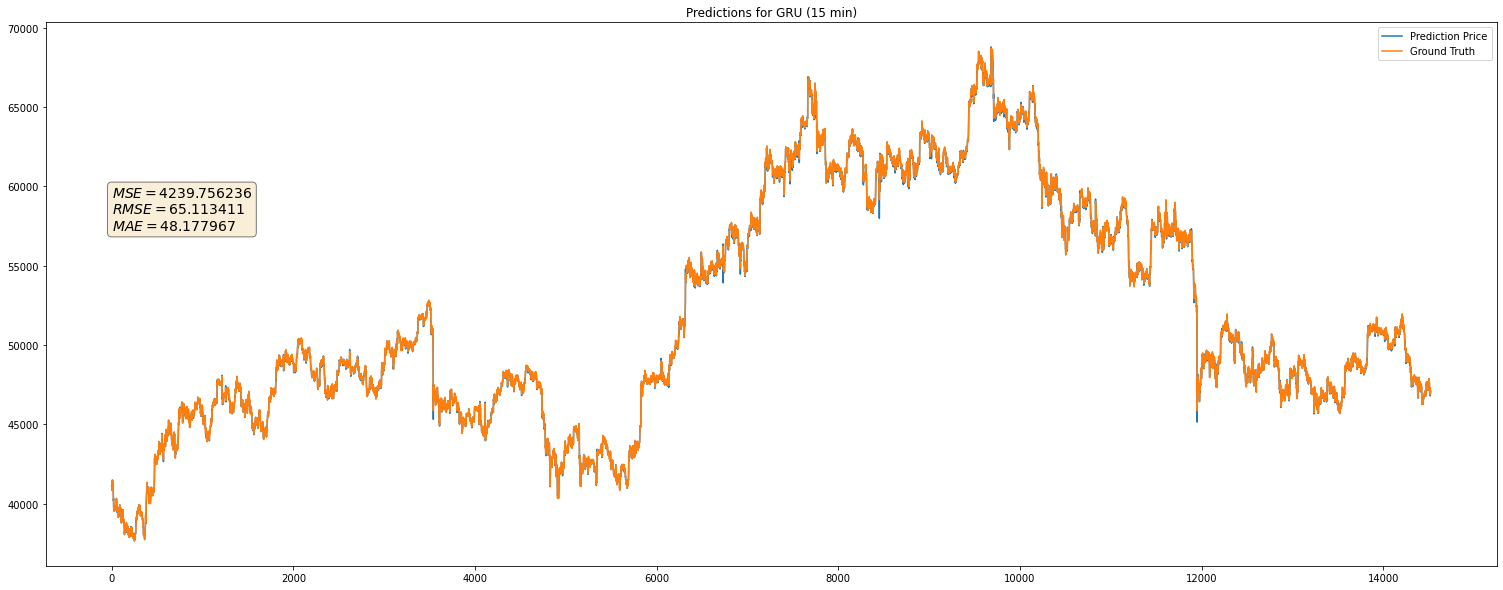

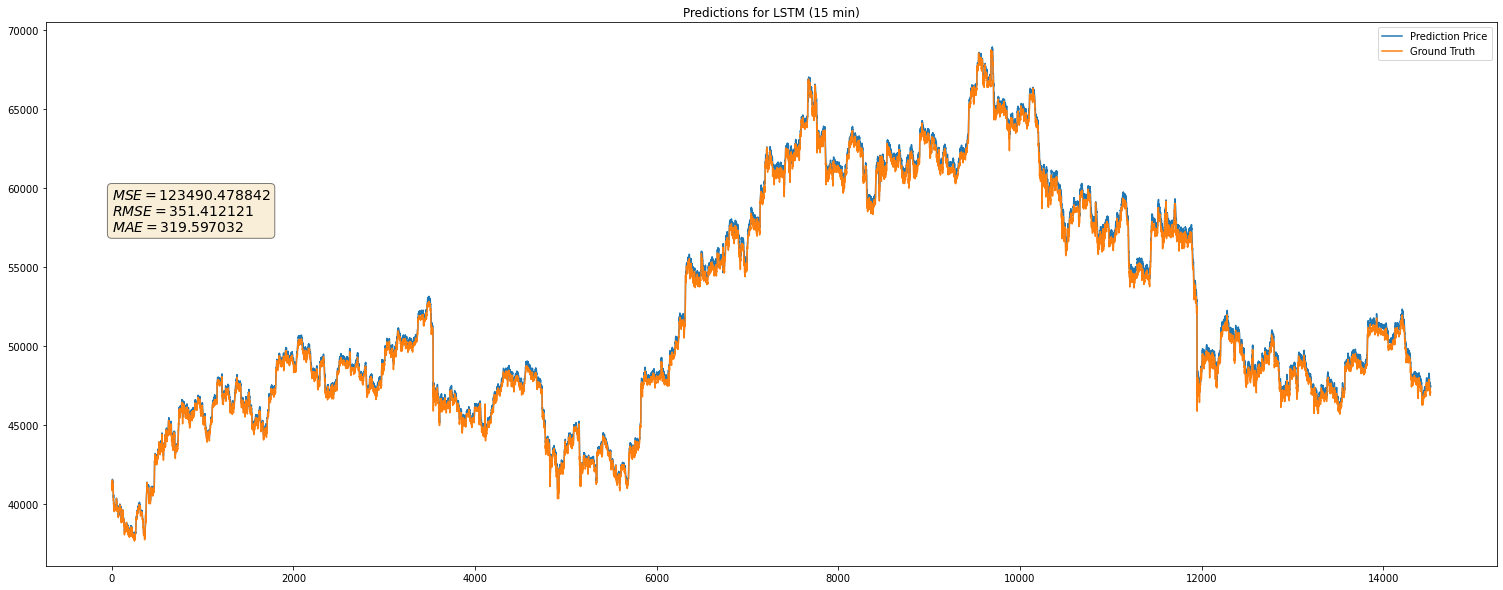

In [11]:
prediction = np.mean(np.array(pred_GRU), axis=0)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for GRU (15 min)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 60000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()


prediction = np.mean(np.array(pred_LSTM), axis=0)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for LSTM (15 min)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 60000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()

In [20]:
pred_GRU = [model.predict(X_train2) for model in GRU]
pred_LSTM = [model.predict(X_train2) for model in LSTM]
pred_LSTM = np.array(pred_LSTM)
pred_GRU = np.array(pred_GRU)

tmp = np.concatenate((pred_GRU, pred_LSTM), axis=0).squeeze().transpose()

In [21]:
batch_size = 8
model = Sequential([
                    Dense(50),
                    Dense(100),
                    Dense(25),
                    Dense(1)
                    ])

model.compile(optimizer= Adam(learning_rate=5e-4), loss='mse', metrics=['accuracy'])

model.fit(tmp, y_train2, batch_size = batch_size, epochs=50, verbose = 1)

Epoch 1/50
1815/1815 [==============================] - 2s 1ms/step - loss: 0.0017 - accuracy: 0.0000e+00
Epoch 2/50
1815/1815 [==============================] - 2s 1ms/step - loss: 6.9911e-06 - accuracy: 0.0000e+00: 0s - loss: 5.7200e-06 - accuracy: 
Epoch 3/50
1815/1815 [==============================] - 2s 1ms/step - loss: 3.5818e-05 - accuracy: 0.0000e+00
Epoch 4/50
1815/1815 [==============================] - 2s 1ms/step - loss: 4.4450e-05 - accuracy: 0.0000e+00
Epoch 5/50
1815/1815 [==============================] - 2s 1ms/step - loss: 2.6742e-05 - accuracy: 0.0000e+00
Epoch 6/50
1815/1815 [==============================] - 2s 1ms/step - loss: 2.6204e-05 - accuracy: 0.0000e+00
Epoch 7/50
1815/1815 [==============================] - 2s 1ms/step - loss: 1.5654e-05 - accuracy: 0.0000e+00
Epoch 8/50
1815/1815 [==============================] - 2s 1ms/step - loss: 1.2305e-05 - accuracy: 0.0000e+00
Epoch 9/50
1815/1815 [==============================] - 2s 1ms/step - loss: 1.0779e-05 -

# Prediction for Meta-Model

In [22]:
pred_GRU = [model.predict(X_test) for model in GRU]
pred_LSTM = [model.predict(X_test) for model in LSTM]

pred_LSTM = np.array(pred_LSTM)
pred_GRU = np.array(pred_GRU)

tmp2 = np.concatenate((pred_GRU, pred_LSTM), axis=0).squeeze().transpose()

prediction = model.predict(tmp2)

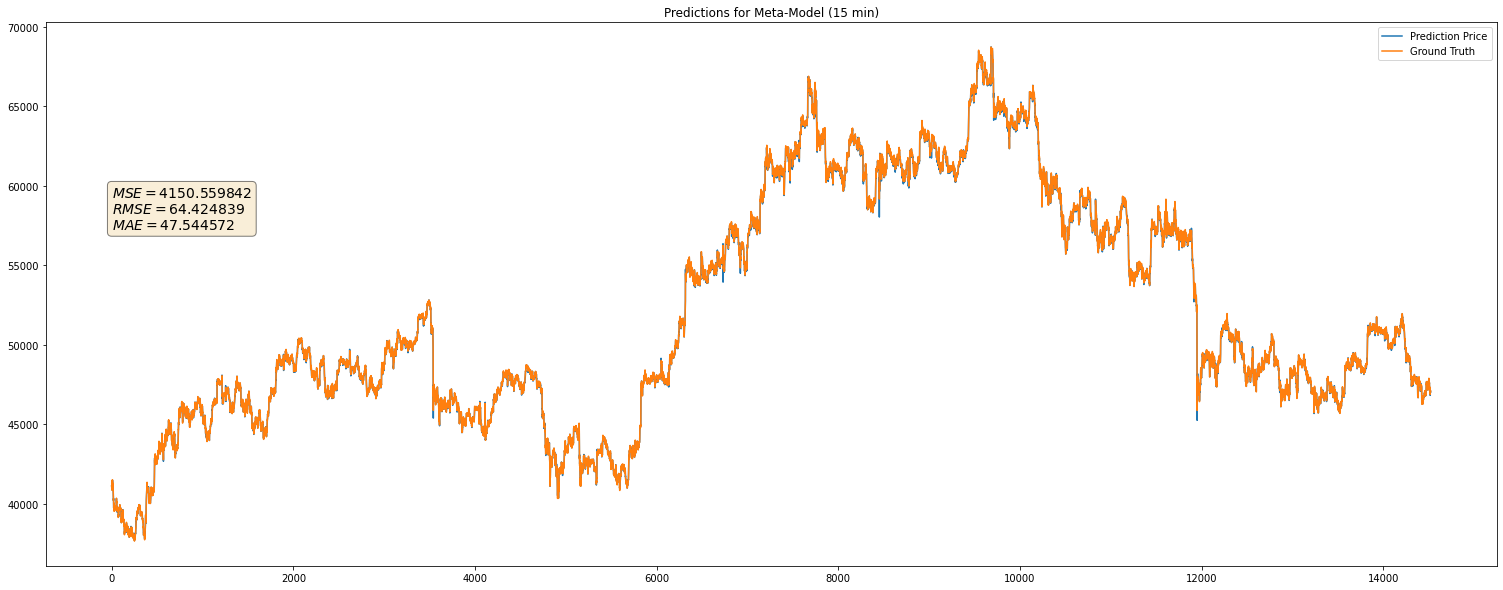

In [23]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for Meta-Model (15 min)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 60000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()